In [1]:
import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Conv1D, UpSampling1D
from tensorflow.keras.layers import MaxPooling1D, InputLayer, Conv1DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
df = pd.read_csv('./data/전체주가Data.csv')
df = df[df['Volume'] != 0]
group_df = df.groupby('name')
names = df.name.unique()

In [3]:
earlystop = EarlyStopping(monitor='val_loss',  
                      patience=5, 
                      verbose=1, 
                      mode='min',
                      restore_best_weights=True )
reducelr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.2, 
                             patience=5, 
                             verbose=0, 
                             mode='min')

In [4]:
def train_test(group_df, keyword=None, predict_period=None, ):
    data = group_df.get_group(f'{keyword}').reset_index(drop=True)
    train, test = train_test_split(data, test_size=0.3, shuffle=False)
    
    scaler = MinMaxScaler()
    scaler.fit(train[['Close']])
    train['Close'] = scaler.transform(train[['Close']])
    test['Close'] = scaler.transform(test[['Close']])
    
    seq_len = 16
    sequence_length = seq_len + predict_period

    train_result = []
    for index in range(len(train['Close'].values) - sequence_length):
        train_result.append(train['Close'].values[index: index + sequence_length])

    test_result = []
    for index in range(len(test['Close'].values) - sequence_length):
        test_result.append(test['Close'].values[index: index + sequence_length])
        
    train_result = np.array(train_result)
    test_result = np.array(test_result)

    np.random.shuffle(train_result)
    
    X_train = train_result[:, :-predict_period]
    y_train = train_result[:, -1]

    X_test = test_result[:, :-predict_period]
    y_test = test_result[:, -1]

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train, X_test, y_train, y_test, scaler

In [5]:
def AutoEncoder(X_train, BATCH_SIZE=None, EPOCHS=None, VALIDATION_SPLIT=None):
    encoder_model = Sequential()
    
    # Encoder
    encoder_model.add(InputLayer(input_shape=(16, 1)))
    encoder_model.add(Conv1D(32, kernel_size=7, strides=2, padding='same', activation='relu'))
    encoder_model.add(Conv1D(16, kernel_size=7, strides=2, padding='same', activation='relu'))
    
    # Decoder
    encoder_model.add(Conv1DTranspose(16, kernel_size=7, strides=2, padding='same', activation='relu'))
    encoder_model.add(Conv1DTranspose(32, kernel_size=7, strides=2, padding='same', activation='relu'))
    encoder_model.add(Conv1DTranspose(1, kernel_size=7, padding='same'))
    
    encoder_model.compile(loss='mse', optimizer='adam')
    
    encoder_model.fit(X_train, X_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=VALIDATION_SPLIT,
              callbacks=[earlystop, reducelr],
              verbose=0)
    
    plt.figure(figsize=(8,5))
    plt.plot(encoder_model.predict(X_train)[0])
    plt.plot(X_train[0])
    plt.show()
    
    return encoder_model

In [6]:
def Modeling(X_train, y_train, BATCH_SIZE=None, EPOCHS=None, VALIDATION_SPLIT=None):
    model = Sequential()

    model.add(LSTM(64, return_sequences=True, input_shape=(16, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    
    model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=VALIDATION_SPLIT,
              callbacks=[earlystop, reducelr])
    
    return model

In [7]:
def Predict(X_test, y_test, model, scaler):
    pred = model.predict(X_test)

    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    pred = scaler.inverse_transform(pred.reshape(-1,1))

    r2 = r2_score(pred, y_test)
    rmse = np.sqrt(mean_squared_error(pred, y_test))

    plt.figure(figsize=(20, 10))
    plt.plot(y_test, 'k', label='True', alpha=0.5)
    plt.plot(pred, '--r', label='Prediction')
    plt.title(f'R2_SCOREL: {r2:.4f}\nRMSE: {rmse:.4f}')
    plt.legend()
    plt.show()
    
    print('FINISH!!!')
    return pred

In [8]:
#Activation 'relu'로 변경하여 cuDNN 커널 사용 불가 **확인필요**

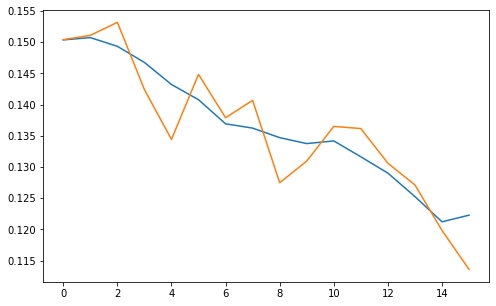

Epoch 1/30
295/295 [==============================] - 6s 11ms/step - loss: 0.0405 - val_loss: 0.0490
Epoch 2/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0107 - val_loss: 0.0186
Epoch 3/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0108 - val_loss: 0.0012
Epoch 4/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0110 - val_loss: 4.8950e-04
Epoch 5/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0096 - val_loss: 7.9208e-04
Epoch 6/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0098 - val_loss: 7.4804e-04
Epoch 7/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0081 - val_loss: 7.0224e-04
Epoch 8/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0102 - val_loss: 0.0026
Epoch 9/30
295/295 [==============================] - 2s 8ms/step - loss: 0.0087 - val_loss: 0.0013
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping

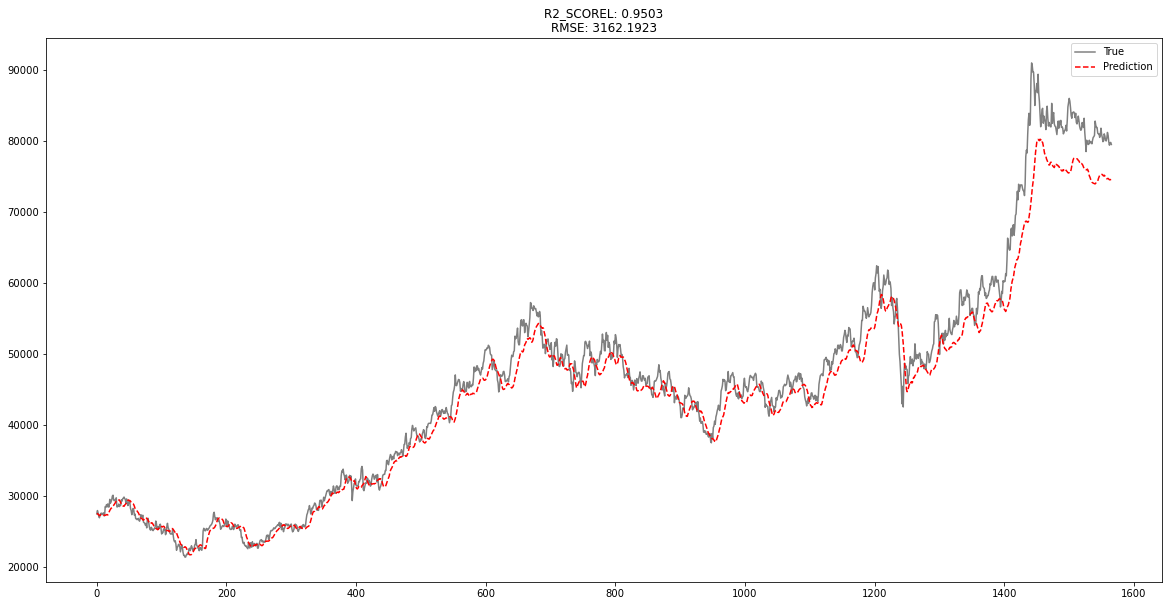

FINISH!!!


In [9]:
X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='삼성전자', predict_period=5)
encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
pred = Predict(X_test, y_test, model, scaler)

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping


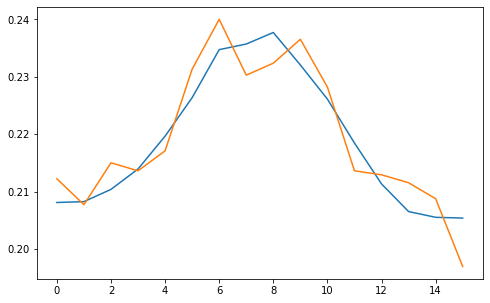

Epoch 1/30
286/286 [==============================] - 6s 11ms/step - loss: 0.0466 - val_loss: 0.0600
Epoch 2/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0175 - val_loss: 0.0250
Epoch 3/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0171 - val_loss: 0.0095
Epoch 4/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0155 - val_loss: 0.0087
Epoch 5/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0157 - val_loss: 0.0122
Epoch 6/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0153 - val_loss: 0.0120
Epoch 7/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0148 - val_loss: 0.0082
Epoch 8/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0149 - val_loss: 0.0128
Epoch 9/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0148 - val_loss: 0.0084
Epoch 10/30
286/286 [==============================] - 2s 8ms/step - loss: 0.0155 - val_loss: 0.008

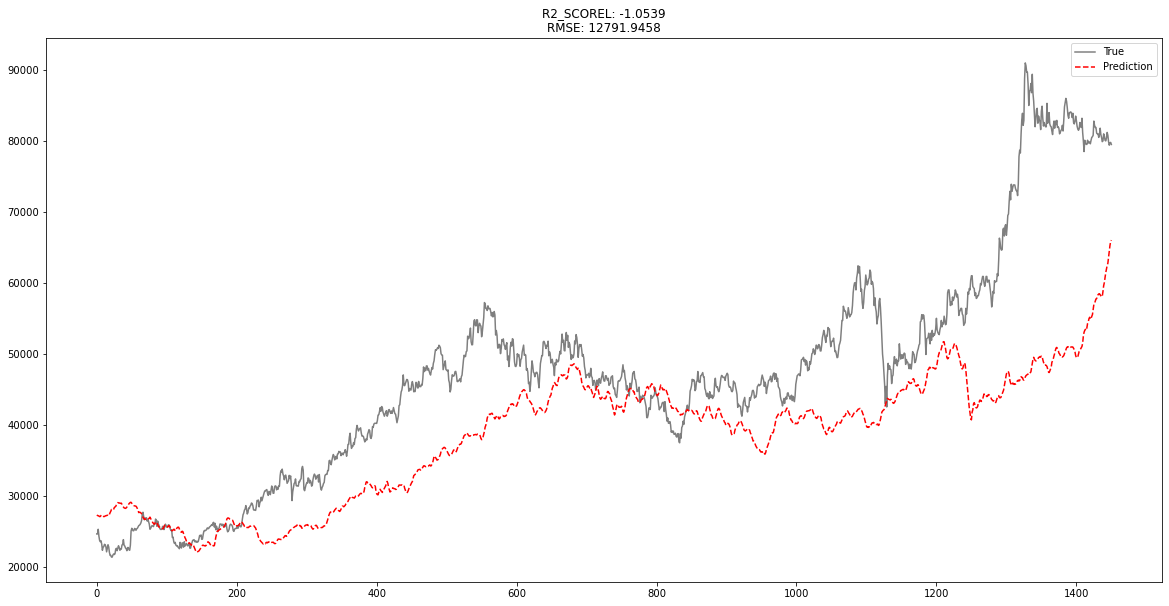

FINISH!!!


In [10]:
X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='삼성전자', predict_period=120)
encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
pred = Predict(X_test, y_test, model, scaler)

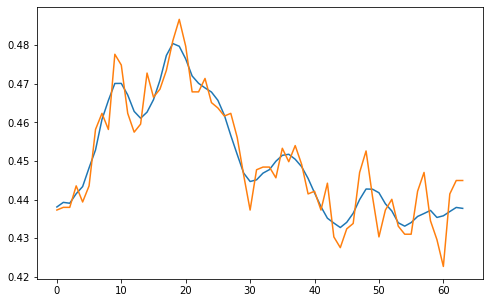

Epoch 1/30
291/291 [==============================] - 10s 23ms/step - loss: 0.0453 - val_loss: 0.0494
Epoch 2/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0111 - val_loss: 0.0159
Epoch 3/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0098 - val_loss: 0.0021
Epoch 4/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0105 - val_loss: 6.5813e-04
Epoch 5/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0111 - val_loss: 7.9498e-04
Epoch 6/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0096 - val_loss: 0.0010
Epoch 7/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0092 - val_loss: 5.9711e-04
Epoch 8/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0093 - val_loss: 0.0026
Epoch 9/30
291/291 [==============================] - 6s 21ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 10/30
291/291 [==============================] - 6s 22ms/step - loss: 0.

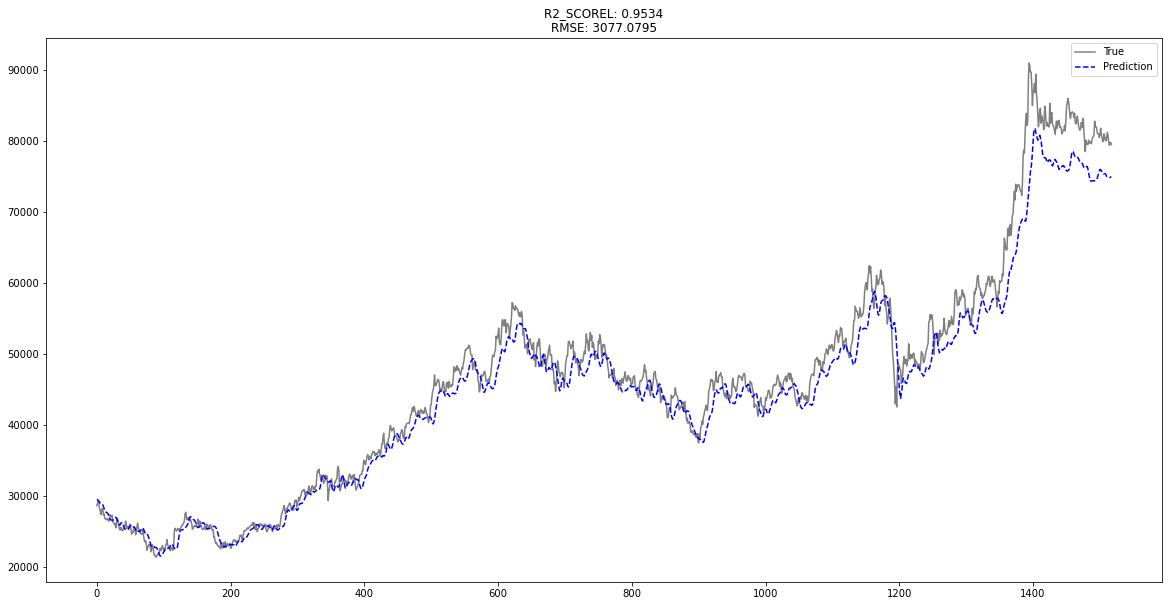

FINISH!!!


In [9]:
X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='삼성전자', predict_period=5)
encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
pred = Predict(X_test, y_test, model, scaler)

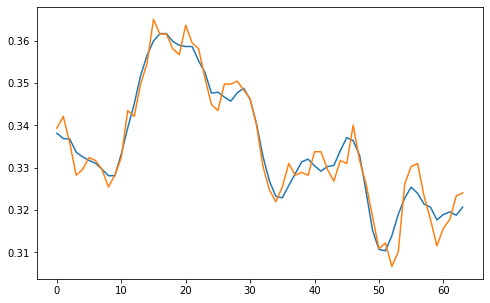

Epoch 1/30
290/290 [==============================] - 10s 24ms/step - loss: 0.0512 - val_loss: 0.0502
Epoch 2/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0129 - val_loss: 0.0162
Epoch 3/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0127 - val_loss: 0.0046
Epoch 4/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0130 - val_loss: 0.0026
Epoch 5/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0101 - val_loss: 0.0018
Epoch 6/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0108 - val_loss: 0.0029
Epoch 7/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 8/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0103 - val_loss: 0.0021
Epoch 9/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0113 - val_loss: 0.0028
Epoch 10/30
290/290 [==============================] - 6s 21ms/step - loss: 0.0111 - val_l

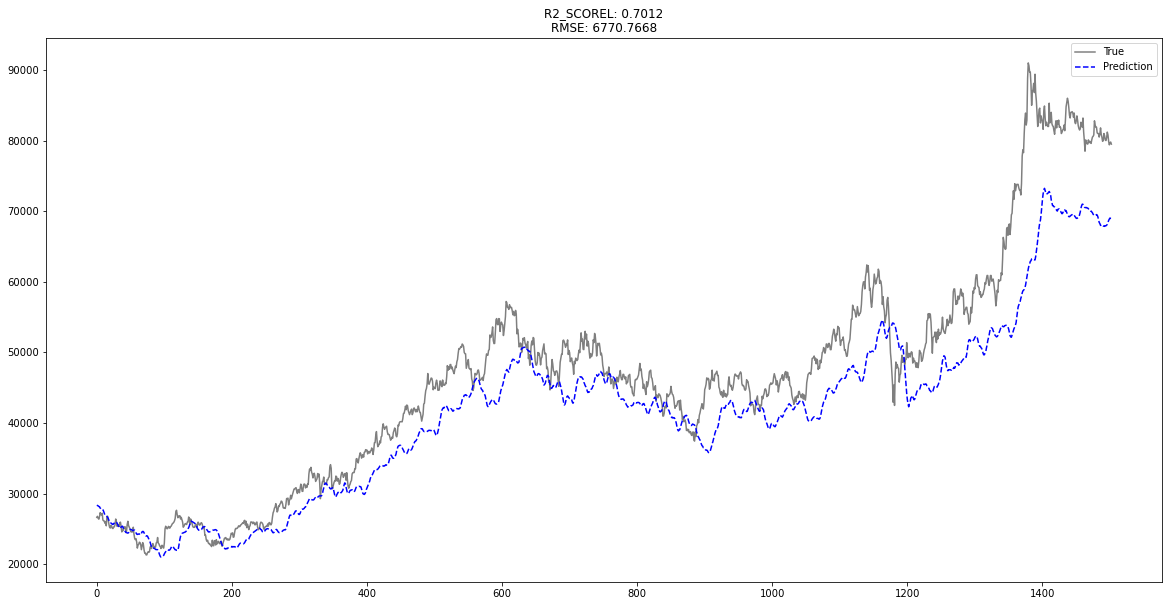

FINISH!!!


In [10]:
X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='삼성전자', predict_period=20)
encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
pred = Predict(X_test, y_test, model, scaler)

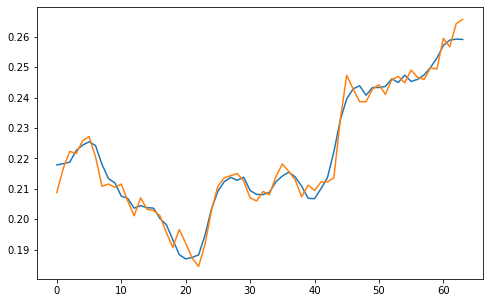

Epoch 1/30
287/287 [==============================] - 10s 24ms/step - loss: 0.0550 - val_loss: 0.0490
Epoch 2/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0141 - val_loss: 0.0250
Epoch 3/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0150 - val_loss: 0.0047
Epoch 4/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0148 - val_loss: 0.0105
Epoch 5/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0145 - val_loss: 0.0049
Epoch 6/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0140 - val_loss: 0.0045
Epoch 7/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0145 - val_loss: 0.0100
Epoch 8/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0132 - val_loss: 0.0052
Epoch 9/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0122 - val_loss: 0.0058
Epoch 10/30
287/287 [==============================] - 6s 21ms/step - loss: 0.0127 - val_l

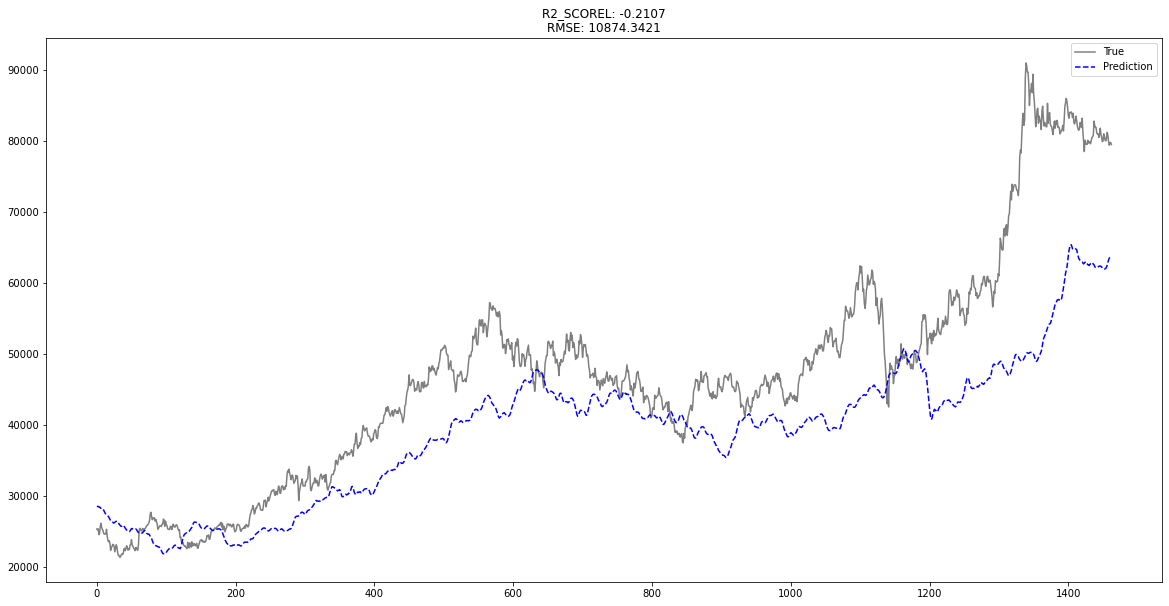

FINISH!!!


In [11]:
X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='삼성전자', predict_period=60)
encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
pred = Predict(X_test, y_test, model, scaler)

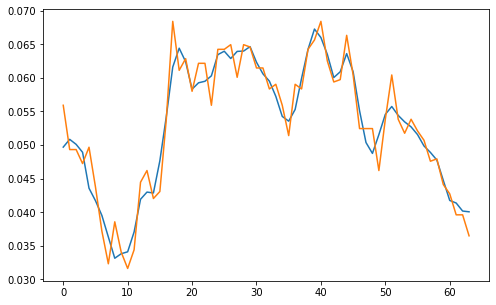

Epoch 1/30
282/282 [==============================] - 10s 24ms/step - loss: 0.0432 - val_loss: 0.0506
Epoch 2/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0179 - val_loss: 0.0249
Epoch 3/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0177 - val_loss: 0.0090
Epoch 4/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0162 - val_loss: 0.0077
Epoch 5/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0156 - val_loss: 0.0096
Epoch 6/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0160 - val_loss: 0.0073
Epoch 7/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0159 - val_loss: 0.0125
Epoch 8/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0144 - val_loss: 0.0078
Epoch 9/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0154 - val_loss: 0.0074
Epoch 10/30
282/282 [==============================] - 6s 21ms/step - loss: 0.0153 - val_l

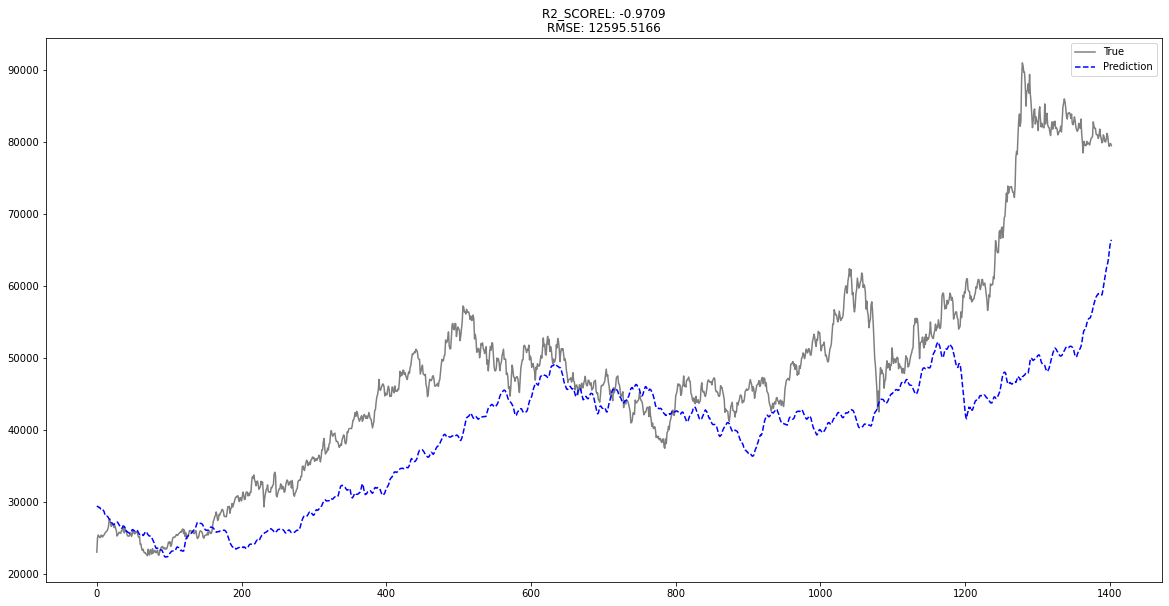

FINISH!!!


In [12]:
X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='삼성전자', predict_period=120)
encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
pred = Predict(X_test, y_test, model, scaler)

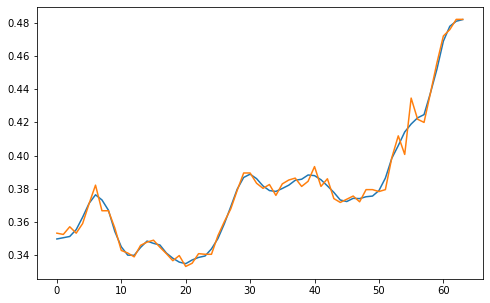

Epoch 1/30
288/288 [==============================] - 11s 29ms/step - loss: 0.0096 - val_loss: 0.0120
Epoch 2/30
288/288 [==============================] - 8s 26ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 3/30
288/288 [==============================] - 8s 26ms/step - loss: 0.0031 - val_loss: 4.9492e-04
Epoch 4/30
288/288 [==============================] - 8s 26ms/step - loss: 0.0030 - val_loss: 8.5946e-04
Epoch 5/30
288/288 [==============================] - 8s 27ms/step - loss: 0.0029 - val_loss: 8.0818e-04
Epoch 6/30
288/288 [==============================] - 8s 27ms/step - loss: 0.0027 - val_loss: 4.5368e-04
Epoch 7/30
288/288 [==============================] - 8s 27ms/step - loss: 0.0026 - val_loss: 5.6331e-04
Epoch 8/30
288/288 [==============================] - 8s 27ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 9/30
288/288 [==============================] - 8s 27ms/step - loss: 0.0024 - val_loss: 6.4492e-04
Epoch 10/30
288/288 [==============================] - 8s 27ms/ste

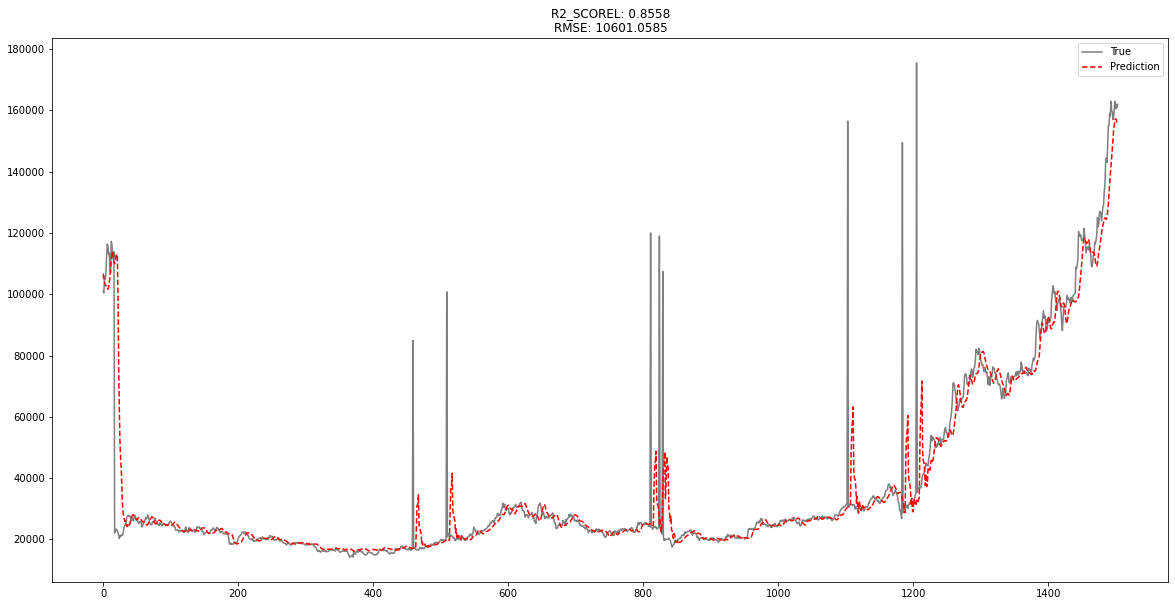

FINISH!!!


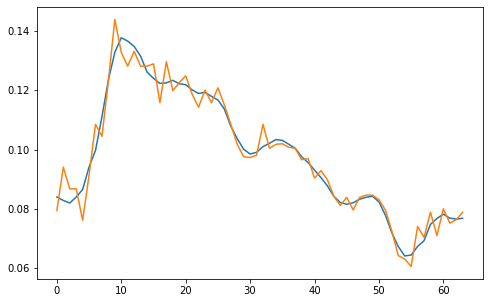

Epoch 1/30
287/287 [==============================] - 9s 22ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 2/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 3/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 4/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 5/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 7/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 8/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 9/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 10/30
287/287 [==============================] - 6s 20ms/step - loss: 0.0033 - val_lo

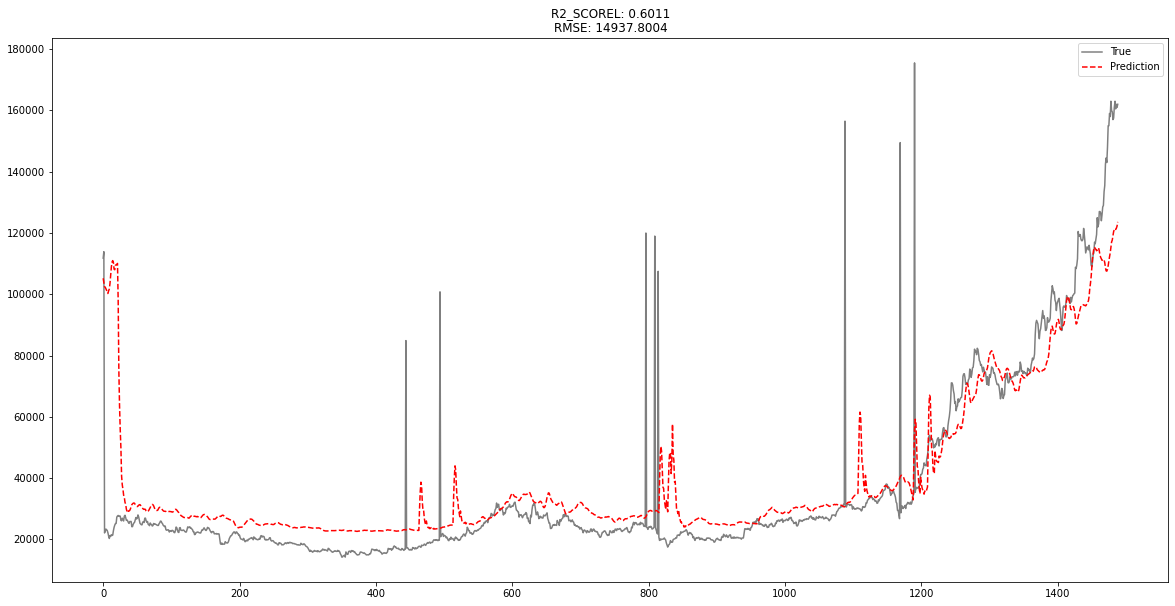

FINISH!!!


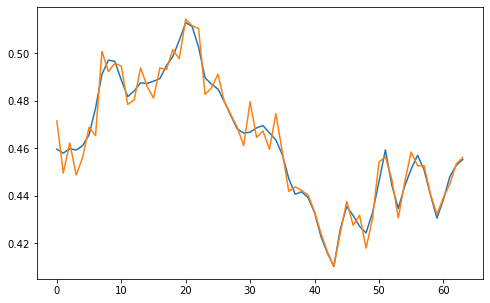

Epoch 1/30
284/284 [==============================] - 9s 22ms/step - loss: 0.0198 - val_loss: 0.0134
Epoch 2/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0065 - val_loss: 0.0083
Epoch 3/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0061 - val_loss: 0.0038
Epoch 4/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 6/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 7/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 8/30
284/284 [==============================] - 6s 20ms/step - loss: 0.0058 - val_loss: 0.0047
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


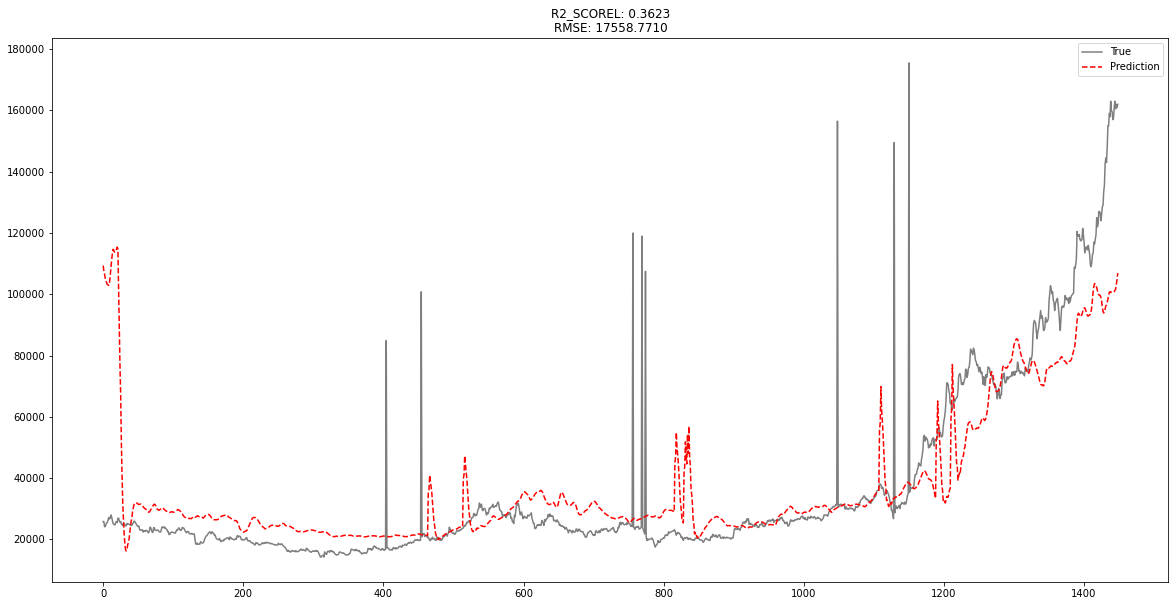

FINISH!!!


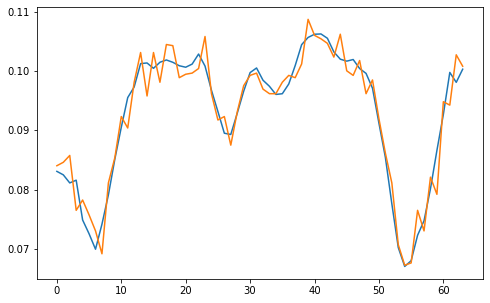

Epoch 1/30
279/279 [==============================] - 9s 22ms/step - loss: 0.0188 - val_loss: 0.0150
Epoch 2/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 3/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 4/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 5/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0090 - val_loss: 0.0139
Epoch 6/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 7/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 8/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 9/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 10/30
279/279 [==============================] - 6s 20ms/step - loss: 0.0087 - val_lo

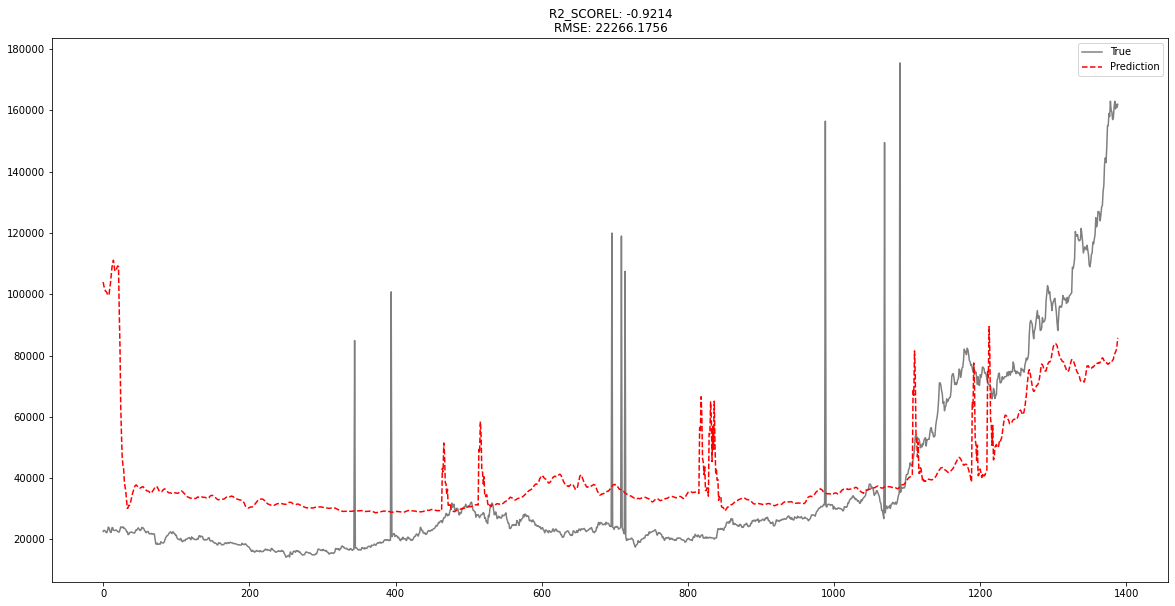

FINISH!!!


In [8]:
period_lst = [5, 20, 60, 120]

for p in period_lst:
    X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='카카오', predict_period=p)
    encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
    X_train = encoder.predict(X_train)
    X_test = encoder.predict(X_test)

    model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
    pred = Predict(X_test, y_test, model, scaler)

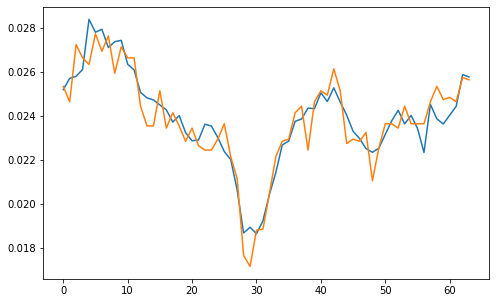

Epoch 1/30
290/290 [==============================] - 9s 22ms/step - loss: 0.0443 - val_loss: 0.0463
Epoch 2/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0112 - val_loss: 0.0092
Epoch 3/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0107 - val_loss: 0.0033
Epoch 4/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0095 - val_loss: 9.1574e-04
Epoch 5/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0087 - val_loss: 0.0013
Epoch 6/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0090 - val_loss: 0.0024
Epoch 7/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0093 - val_loss: 0.0045
Epoch 8/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0090 - val_loss: 6.8401e-04
Epoch 9/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0082 - val_loss: 8.7408e-04
Epoch 10/30
290/290 [==============================] - 6s 20ms/step - loss: 0.0

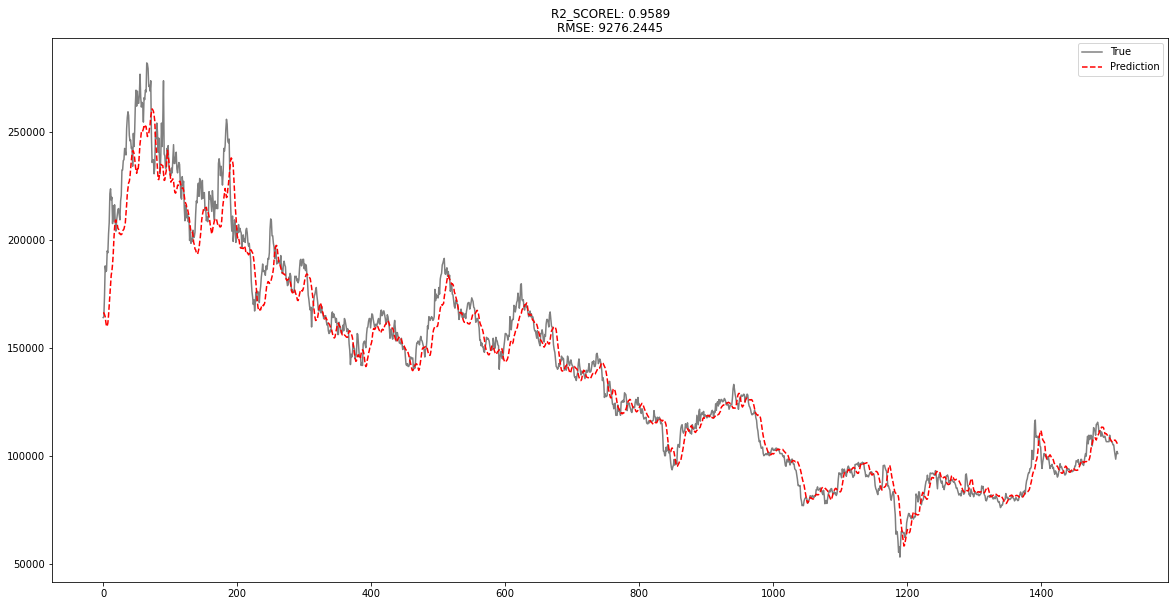

FINISH!!!
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping


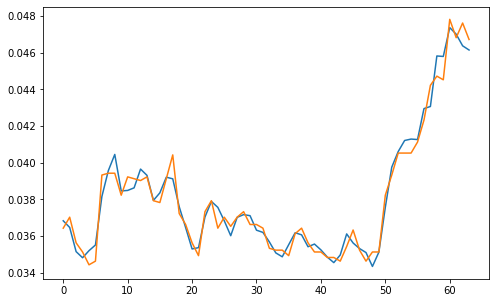

Epoch 1/30
289/289 [==============================] - 9s 22ms/step - loss: 0.0235 - val_loss: 0.0513
Epoch 2/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0106 - val_loss: 0.0170
Epoch 3/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0100 - val_loss: 0.0033
Epoch 4/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0113 - val_loss: 0.0072
Epoch 5/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0102 - val_loss: 0.0026
Epoch 6/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0105 - val_loss: 0.0035
Epoch 7/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 8/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0091 - val_loss: 0.0038
Epoch 9/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 10/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0098 - val_lo

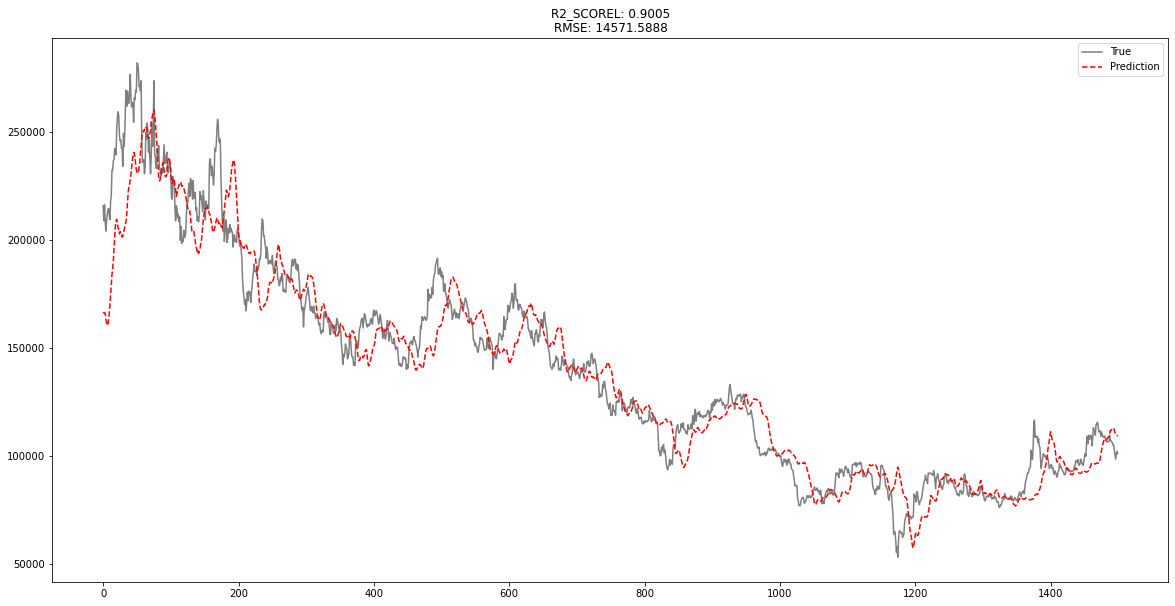

FINISH!!!


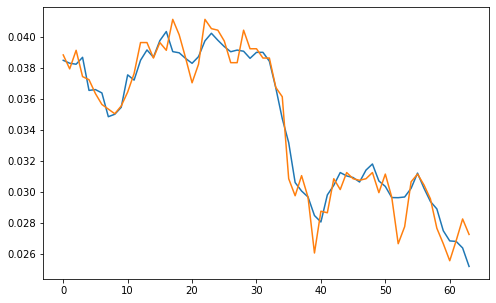

Epoch 1/30
286/286 [==============================] - 9s 22ms/step - loss: 0.0316 - val_loss: 0.0488
Epoch 2/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 3/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0147 - val_loss: 0.0059
Epoch 4/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 5/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0129 - val_loss: 0.0083
Epoch 6/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0137 - val_loss: 0.0068
Epoch 7/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0124 - val_loss: 0.0066
Epoch 8/30
286/286 [==============================] - 6s 20ms/step - loss: 0.0132 - val_loss: 0.0097
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


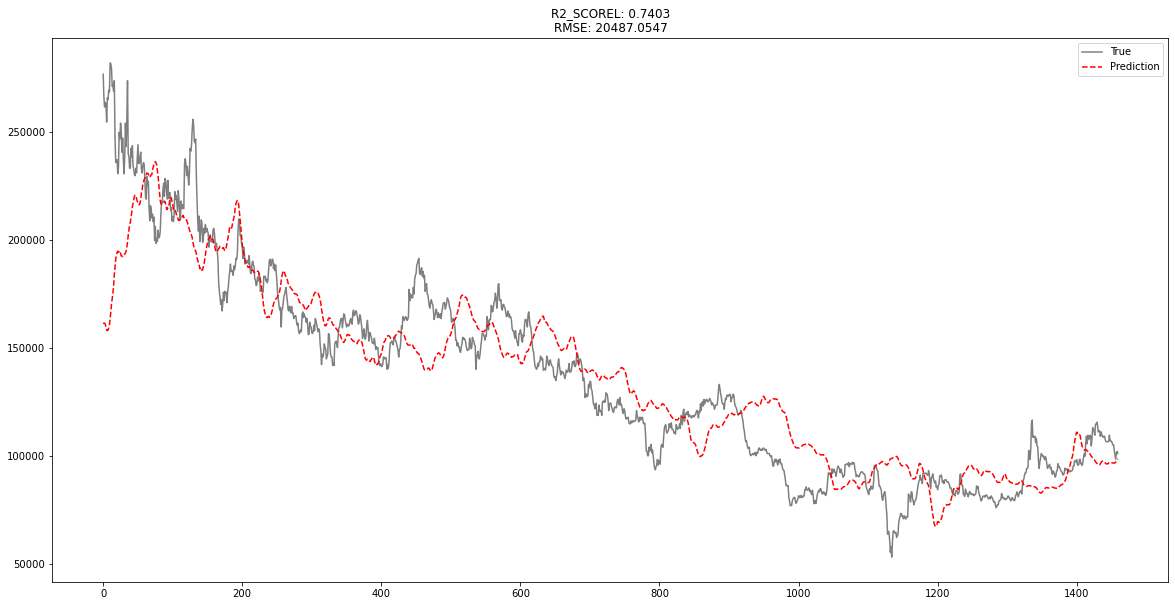

FINISH!!!


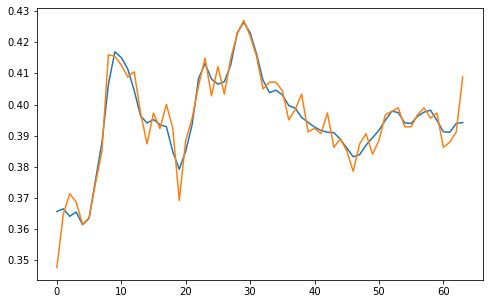

Epoch 1/30
281/281 [==============================] - 9s 22ms/step - loss: 0.0608 - val_loss: 0.0486
Epoch 2/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0205 - val_loss: 0.0225
Epoch 3/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0192 - val_loss: 0.0098
Epoch 4/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0195 - val_loss: 0.0103
Epoch 5/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0187 - val_loss: 0.0097
Epoch 6/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0175 - val_loss: 0.0106
Epoch 7/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0180 - val_loss: 0.0105
Epoch 8/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0182 - val_loss: 0.0170
Epoch 9/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0183 - val_loss: 0.0169
Epoch 10/30
281/281 [==============================] - 6s 20ms/step - loss: 0.0172 - val_lo

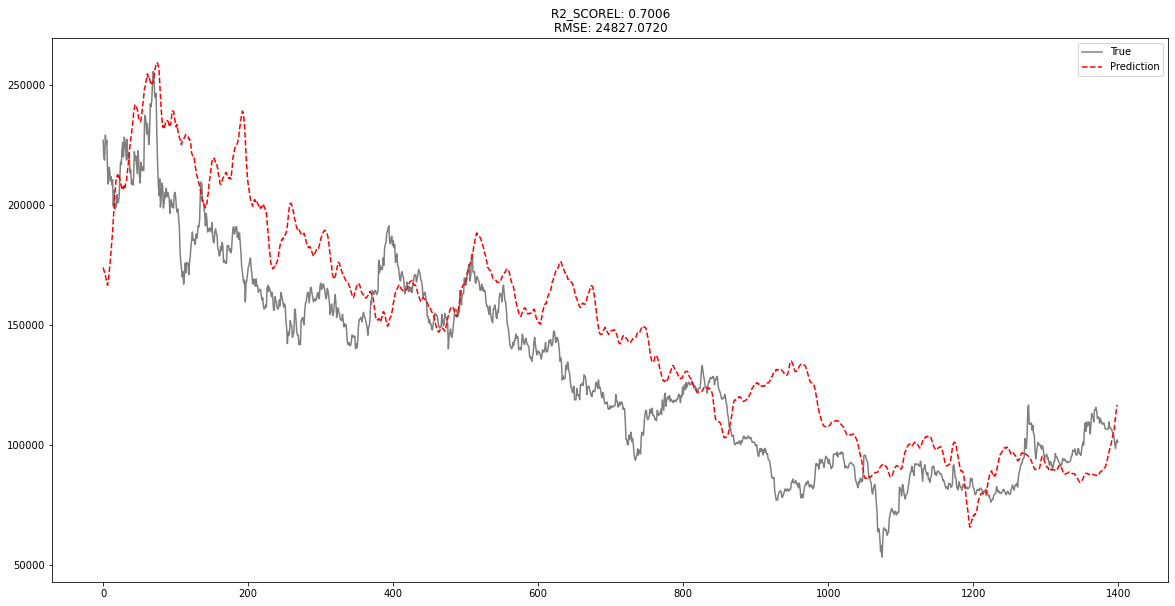

FINISH!!!


In [11]:
period_lst = [5, 20, 60, 120]

for p in period_lst:
    X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='CJ', predict_period=p)
    encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
    X_train = encoder.predict(X_train)
    X_test = encoder.predict(X_test)

    model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
    pred = Predict(X_test, y_test, model, scaler)

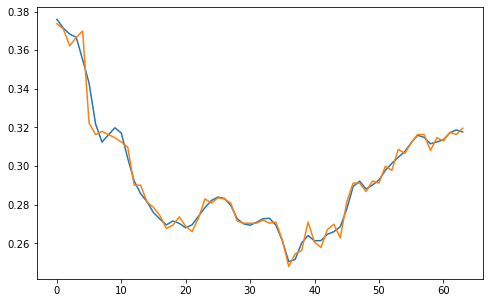

Epoch 1/30
289/289 [==============================] - 9s 22ms/step - loss: 0.0309 - val_loss: 0.0460
Epoch 2/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0113 - val_loss: 0.0203
Epoch 3/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0094 - val_loss: 0.0022
Epoch 4/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0095 - val_loss: 0.0011
Epoch 5/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0096 - val_loss: 0.0021
Epoch 6/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 7/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0089 - val_loss: 0.0010
Epoch 8/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0081 - val_loss: 0.0020
Epoch 9/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0089 - val_loss: 9.5270e-04
Epoch 10/30
289/289 [==============================] - 6s 20ms/step - loss: 0.0079 - va

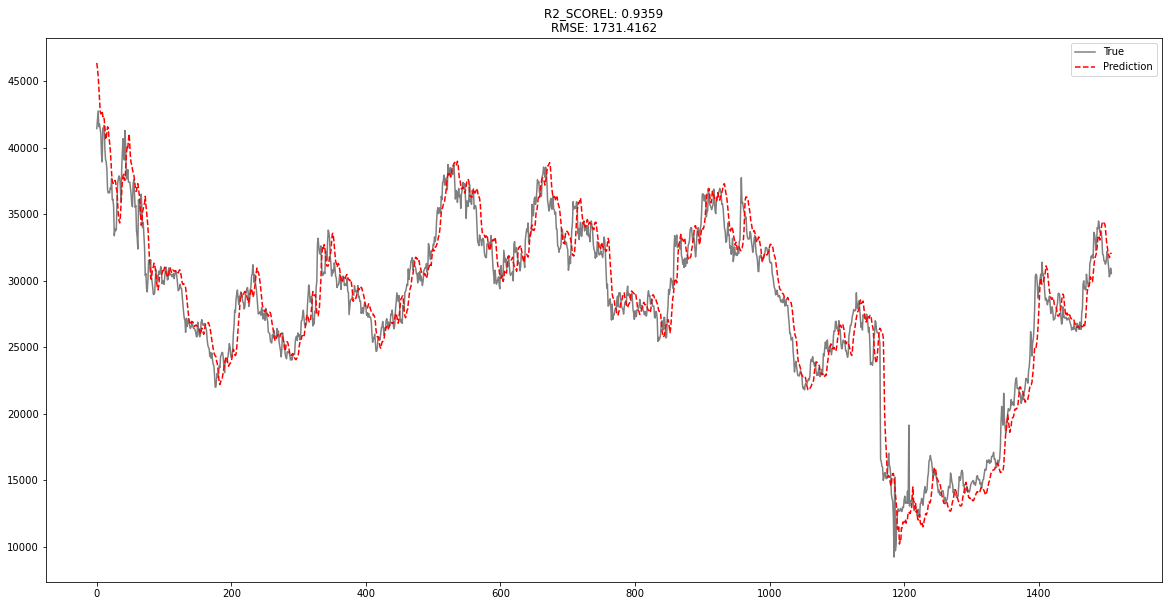

FINISH!!!


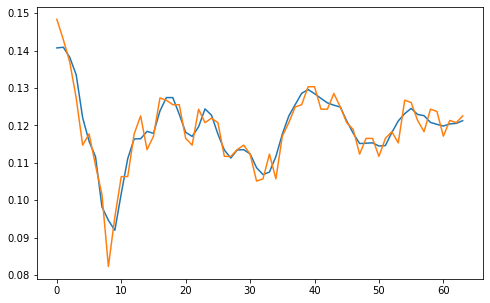

Epoch 1/30
288/288 [==============================] - 9s 22ms/step - loss: 0.0298 - val_loss: 0.0437
Epoch 2/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0132 - val_loss: 0.0128
Epoch 3/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0116 - val_loss: 0.0060
Epoch 4/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0111 - val_loss: 0.0032
Epoch 5/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0120 - val_loss: 0.0030
Epoch 6/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0109 - val_loss: 0.0028
Epoch 7/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0102 - val_loss: 0.0065
Epoch 8/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 9/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0104 - val_loss: 0.0047
Epoch 10/30
288/288 [==============================] - 6s 20ms/step - loss: 0.0085 - val_lo

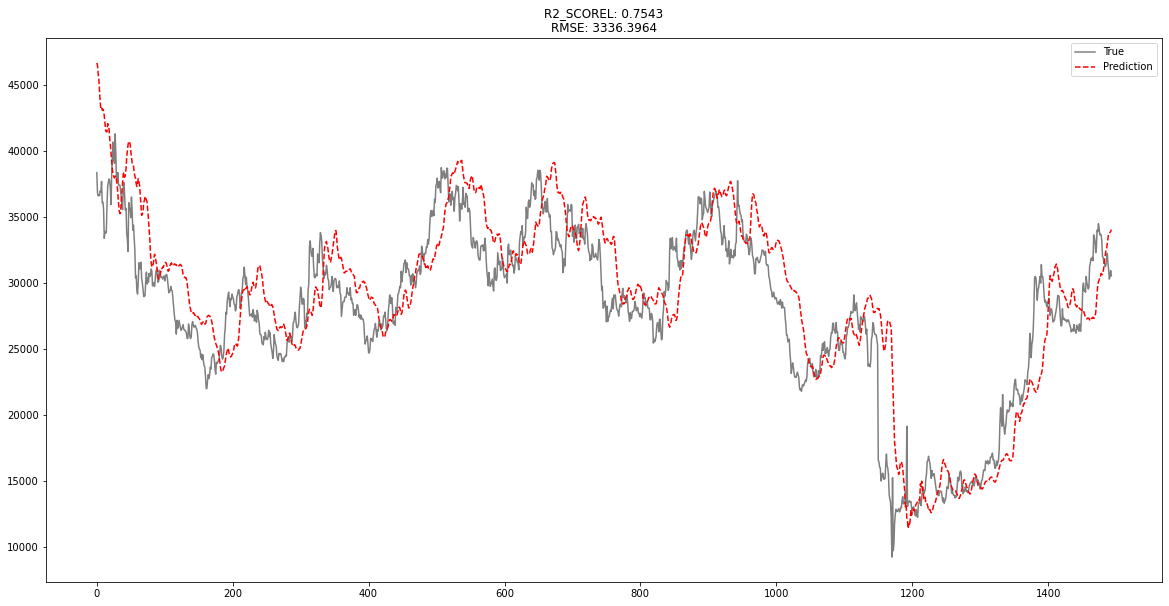

FINISH!!!


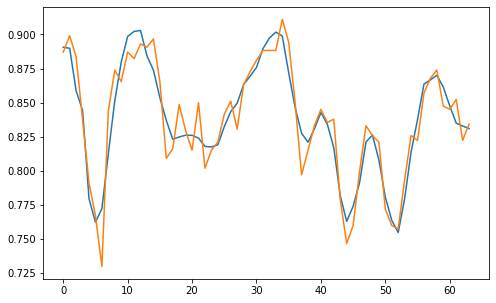

Epoch 1/30
285/285 [==============================] - 9s 22ms/step - loss: 0.0471 - val_loss: 0.0424
Epoch 2/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0163 - val_loss: 0.0231
Epoch 3/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0156 - val_loss: 0.0134
Epoch 4/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0153 - val_loss: 0.0098
Epoch 5/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0166 - val_loss: 0.0121
Epoch 6/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0149 - val_loss: 0.0069
Epoch 7/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 8/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0153 - val_loss: 0.0112
Epoch 9/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0154 - val_loss: 0.0071
Epoch 10/30
285/285 [==============================] - 6s 20ms/step - loss: 0.0143 - val_lo

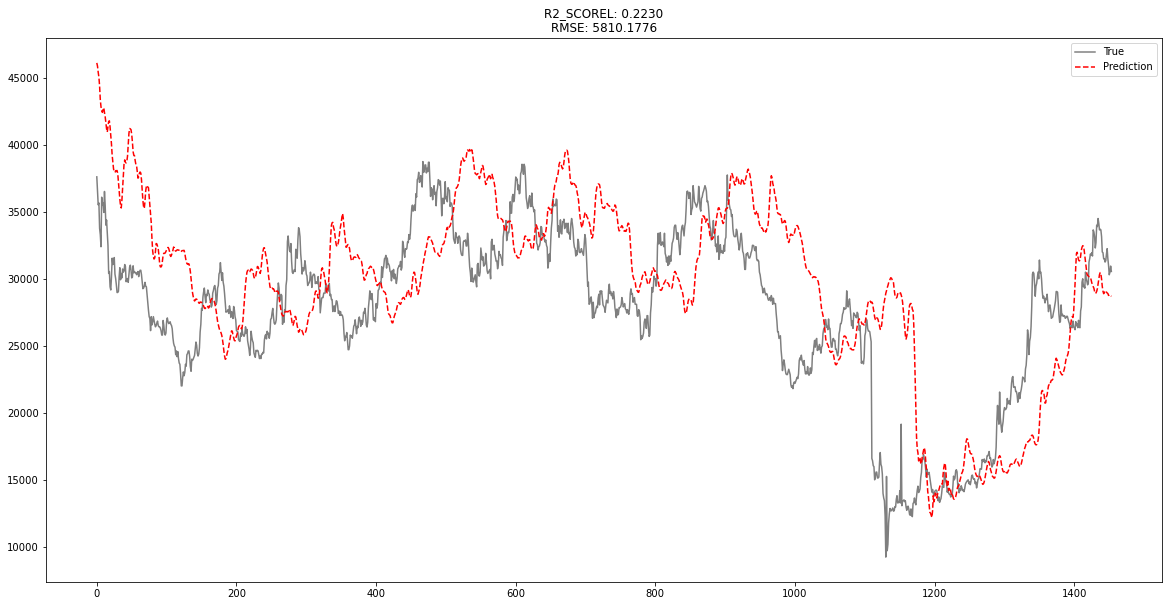

FINISH!!!


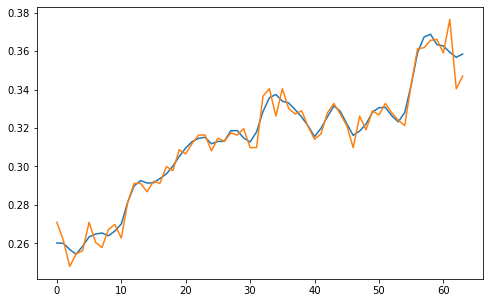

Epoch 1/30
280/280 [==============================] - 9s 22ms/step - loss: 0.0413 - val_loss: 0.0517
Epoch 2/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0232 - val_loss: 0.0265
Epoch 3/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0230 - val_loss: 0.0210
Epoch 4/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0220 - val_loss: 0.0203
Epoch 5/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0214 - val_loss: 0.0224
Epoch 6/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0212 - val_loss: 0.0155
Epoch 7/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0202 - val_loss: 0.0164
Epoch 8/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0205 - val_loss: 0.0207
Epoch 9/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0208 - val_loss: 0.0162
Epoch 10/30
280/280 [==============================] - 6s 20ms/step - loss: 0.0203 - val_lo

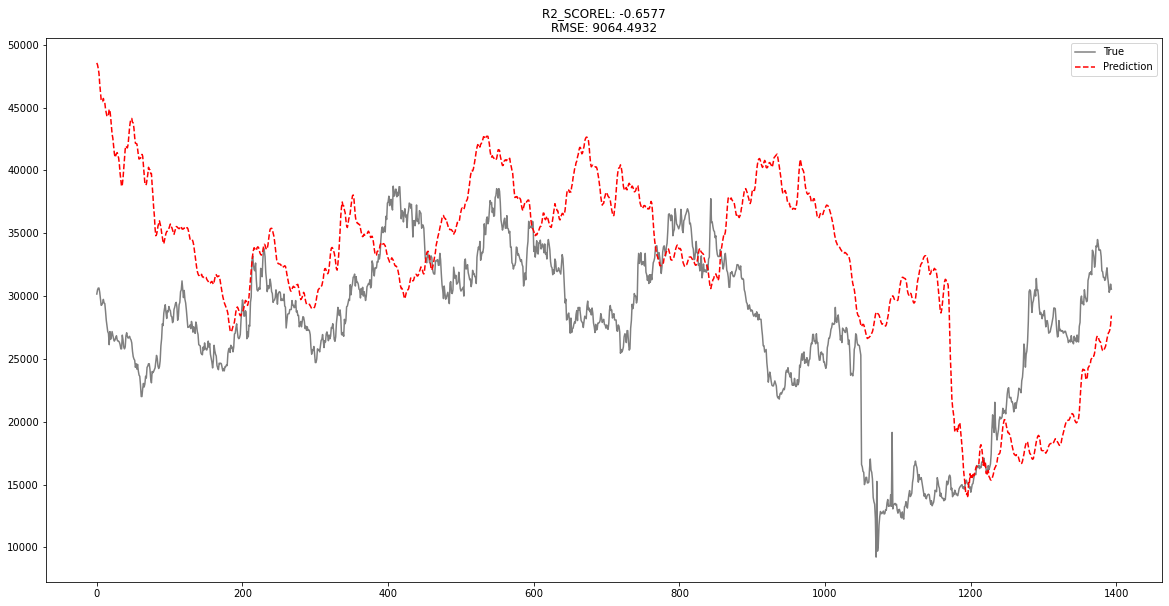

FINISH!!!


In [12]:
period_lst = [5, 20, 60, 120]

for p in period_lst:
    X_train, X_test, y_train, y_test, scaler = train_test(group_df, keyword='대한항공', predict_period=p)
    encoder = AutoEncoder(X_train, BATCH_SIZE=10, EPOCHS=50, VALIDATION_SPLIT=0.2)
    X_train = encoder.predict(X_train)
    X_test = encoder.predict(X_test)

    model = Modeling(X_train, y_train, BATCH_SIZE=10, EPOCHS=30, VALIDATION_SPLIT=0.2)
    pred = Predict(X_test, y_test, model, scaler)